# up and running with prefect
Many types of applications involve executing many subtasks, some of which may be resource-intensive or long-running, and which may fail at any time for multiple reasons. Being able to define tasks, chain them together, and monitor execution is a nontrivial part of any modern computational pipeline.

`prefect` is an open source workflow management library built to address this problem. [prefect.io](Prefect), the company behind the `prefect` library (also known as [Prefect Core](https://www.prefect.io/core) in the official documentation), offers a cloud-based task management dashboard called [Prefect Cloud](https://www.prefect.io/cloud/) as their flagship product. By itself, the `prefect` library is [open source](https://github.com/PrefectHQ/prefect) and totally free to use.



## what are other task management systems?
* [Apache Airflow](https://airflow.apache.org/)
* [Luigi](https://github.com/spotify/luigi)

* a little background how old?

The first public release of prefect, v0.2.0, was released in July of 2018. Since then the Prefect team has released on a regular cadence, adding features and addressing bugs. 

## the example 

In this example, we'll create a simple `prefect` pipeline. We'll write _tasks_ (individual steps in an overall pipeline), create a _flow_ (a series of tasks), and visualize our task graph using `graphviz`.

We start by installing `prefect`; we'll also need [pandas](https://pandas.pydata.org/) and [numpy](https://numpy.org/):

`pip install prefect prefect[viz] pandas numpy scikit-learn`

`prefect[viz]` is an optional extra which is only needed if you want to generate flow visualizations with `graphviz`. 

In [17]:
    import prefect, pandas as pd, numpy, sklearn.datasets as sd

In [25]:
data, _ = sd.make_blobs(n_features=3)
pd.DataFrame(data, columns=['a', 'b', 'c'])

,a,b,c
0,6.373007,8.546682,-4.873265
1,8.102369,0.018026,-2.739402
2,7.632281,8.073282,-4.475600
3,8.194697,-1.234067,-1.062361
4,6.629816,10.244118,-5.894895
...,...,...,...
95,8.123895,10.931886,-7.344706
96,8.158797,7.991207,-5.532279
97,4.486044,1.983557,-3.030938
98,-8.708165,6.606006,4.547617


In [22]:
    @prefect.task(nout=2)
    def split(df: pandas.DataFrame, fraction: float = 0.7):
        n_train = int(fraction*len(df))
        return df.iloc[:n_train], df.iloc[n_train:]

In [9]:
    @prefect.task
    def make_random_df(nrows=20):
        return pd.DataFrame(dict(
            a=numpy.random.randint(low=0, high=100, size=nrows), 
            b=numpy.random.randint(low=0, high=100, size=nrows)
        ))

## `prefect` flows

`prefect`'s language and analogies.

    def generate_flow():
        with prefect.Flow('My Flow') as flow:
            random_df = make_random_df(nrows=100)
            train, test = split(df=random_df, fraction=0.7)
        return flow

In [10]:
    def generate_flow():
        with prefect.Flow('My Flow') as flow:
            random_df = make_random_df(nrows=100)
            train, test = split(df=random_df, fraction=0.7)
        return flow

In [12]:
    if __name__ == "__main__":
        flow = generate_flow()
        flow.visualize()
#         import doctest
#         doctest.testmod()

## what and why should continue with `prefect`

One of the most useful features of `prefect` is its ability to generate a task graph using `graphviz`. To generate a graph,

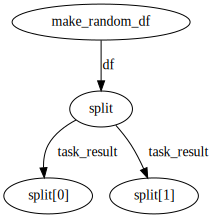

In [13]:
flow = generate_flow()
flow.visualize()

* what other problems could this solve?
Although this example is simple, it could be extended to meet the needs of a full-fledged ML pipeline.